In [1]:
import numpy as np
import open3d as o3d
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm import tqdm
import pickle
from glob import glob
from alphashape import alphashape
from shapely.geometry import Polygon, MultiPolygon

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcds = glob("../data/patch_pcds/*.pcd")
len(pcds)

509

In [3]:
pcd = o3d.io.read_point_cloud("../data/driveable_filtered.pcd")

In [4]:
pcd = pcd.voxel_down_sample(0.7)
points = np.asarray(pcd.points)
points.shape

(57861, 3)

In [5]:
contour = alphashape(points[:, :2], alpha=0.5)

In [6]:
polygons = []
if isinstance(contour, Polygon):
    polygons.append(list(contour.exterior.coords))
else:
    for polygon in contour.geoms:
        polygons.append(list(polygon.exterior.coords))

[]

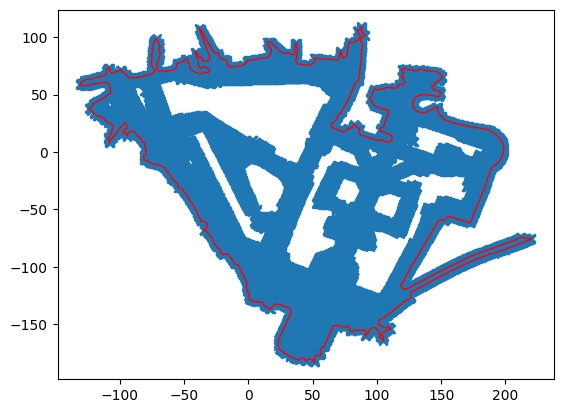

In [7]:
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], marker='x')
for polygon in polygons:
    patch = patches.Polygon(polygon, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(patch)
ax.plot()

In [11]:
from tqdm.contrib.concurrent import process_map  # For parallel processing with progress bar

alpha = 0.5
downsample = 0.5

def process_pcd(cpcd):

    pcd = o3d.io.read_point_cloud(cpcd)
    points = np.asarray(pcd.points)
    
    if points.shape[0] > 1e4:
        pcd = pcd.voxel_down_sample(alpha)
        points = np.asarray(pcd.points)  # Update points after downsampling
    
    contour = alphashape(points[:, :2], alpha=downsample)
    box = pcd.get_axis_aligned_bounding_box()
    extracted_polygons = []
    if isinstance(contour, Polygon):
        extracted_polygons.append(list(contour.exterior.coords))
    elif isinstance(contour, MultiPolygon):
        for polygon in contour.geoms:
            extracted_polygons.append(list(polygon.exterior.coords))
    else:
        pass
    return {f'{box.min_bound[0]}_{box.min_bound[1]}': extracted_polygons}

In [15]:
del polygons

In [16]:
results = process_map(process_pcd, pcds, chunksize=8)

polygons = [poly for sublist in results for poly in sublist]

  0%|          | 0/509 [00:00<?, ?it/s]

In [14]:
polygons

['80.00150299072266_-119.99957275390625',
 '80.101254599435_80.03389994303386',
 '90.11461811680948_-39.88062588136587',
 '118.98869323730469_70.86185455322266',
 '130.16280896735913_-79.88875085336191',
 '-51.90179443359375_30.004549026489258',
 '60.109884873876034_-99.96734619140625',
 '110.00975799560547_-154.57054138183594',
 '130.11135387420654_-9.889952551234853',
 '58.925506591796875_57.147151947021484',
 '4.159416198730469_-65.20440673828125',
 '-59.883352719820465_20.115711248837986',
 '-89.88353850876075_60.11449100353099',
 '-69.88942219660832_-19.872987111409504',
 '-9.8810005738185_70.1186005441766',
 '-109.99569702148438_20.0001163482666',
 '-19.97586441040039_-69.89085569835845',
 '0.10728470845655962_-7.7917176485061646',
 '-9.997604370117188_-19.999958038330078',
 '-39.22966865871263_-19.92111097063337',
 '30.002681732177734_-179.9855194091797',
 '140.00050354003906_-114.010009765625',
 '70.12059020996094_-19.888009504838422',
 '-75.48705291748047_-11.295242309570312',

In [17]:
with open(f"../data/polygons_{alpha*1000}_{downsample*1000}.pkl", "wb") as f:
    pickle.dump(results, f)

In [48]:
opcd = o3d.io.read_point_cloud("../data/driveable_filtered.pcd")
dpcd = opcd.voxel_down_sample(0.7)
dpoints = np.asarray(dpcd.points)
dpoints.shape

(57861, 3)

[]

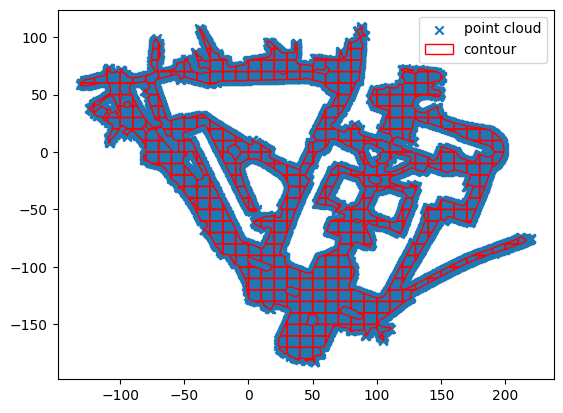

In [49]:
fig, ax = plt.subplots()
ax.scatter(dpoints[:, 0], dpoints[:, 1], marker='x')
for polygon in polygons:
    patch = patches.Polygon(polygon, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(patch)
ax.legend(['point cloud', 'contour'])
ax.plot()

In [50]:
fig.savefig(f"contour_{alpha*1000}_{downsample*1000}.png", )